# Data Engineering Assignment

## 1. Understanding the problem

How can a device be malfunctioning?

1. There are not enough samples for a given time series (based on the number of samples of the on_wrist series)
2. Wrong readings when the device is being worn (out of scale measures)
3. Wrong readings when the device is not being worn

As for 1.: we can see that normalizing the samples to 64 Hz gives out enough samples so that it looks like there is no issue in the sample transmission. Therefore, we can exclude this possible cause

In [1]:
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
import os
import re

from pandas.plotting._matplotlib.style import get_standard_colors

from check_faulty_devices.plot_utils import plot_device_data

## 2. Let's take a look at the data

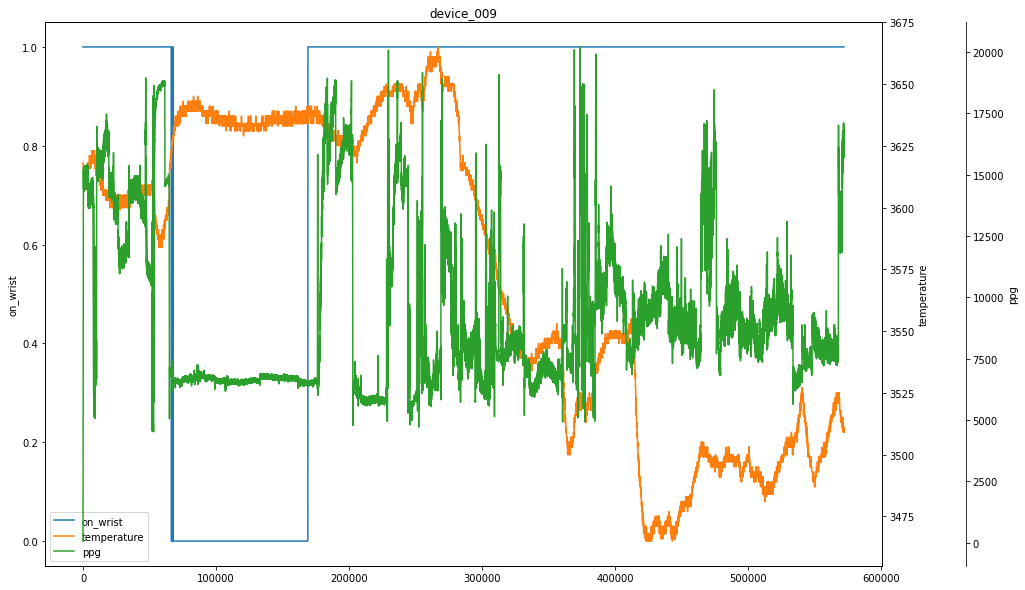

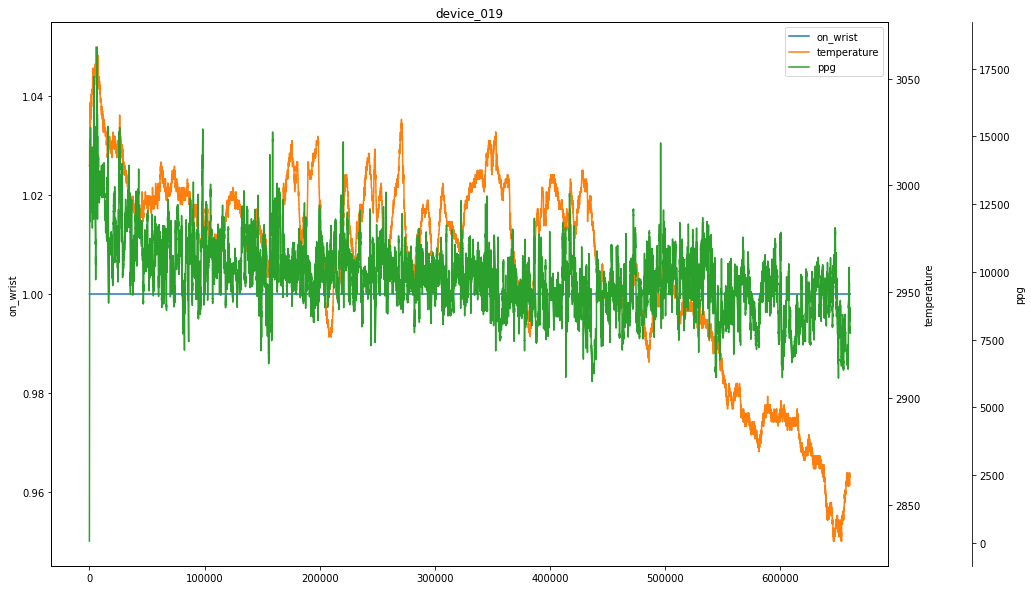

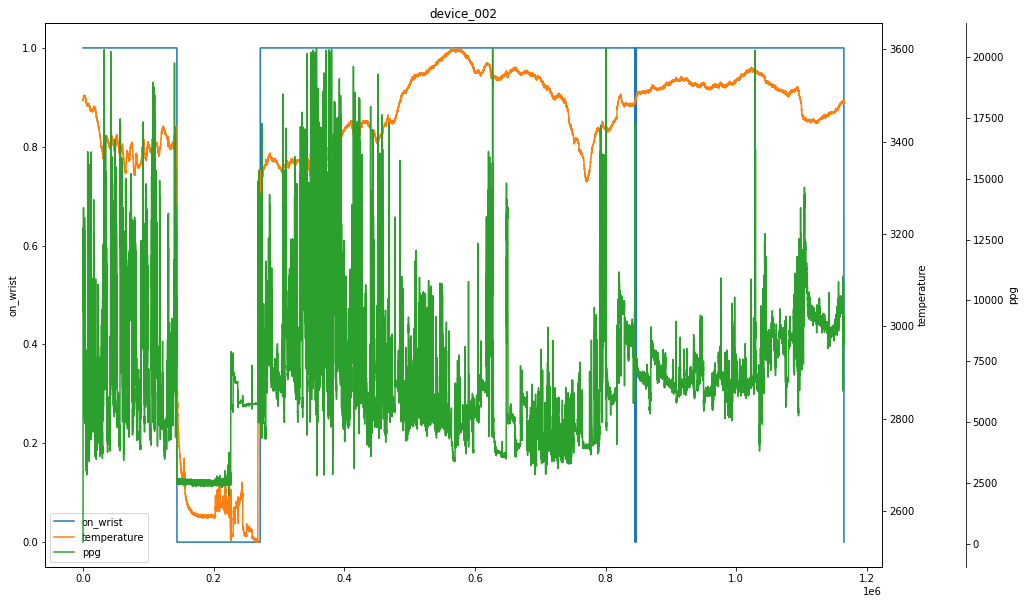

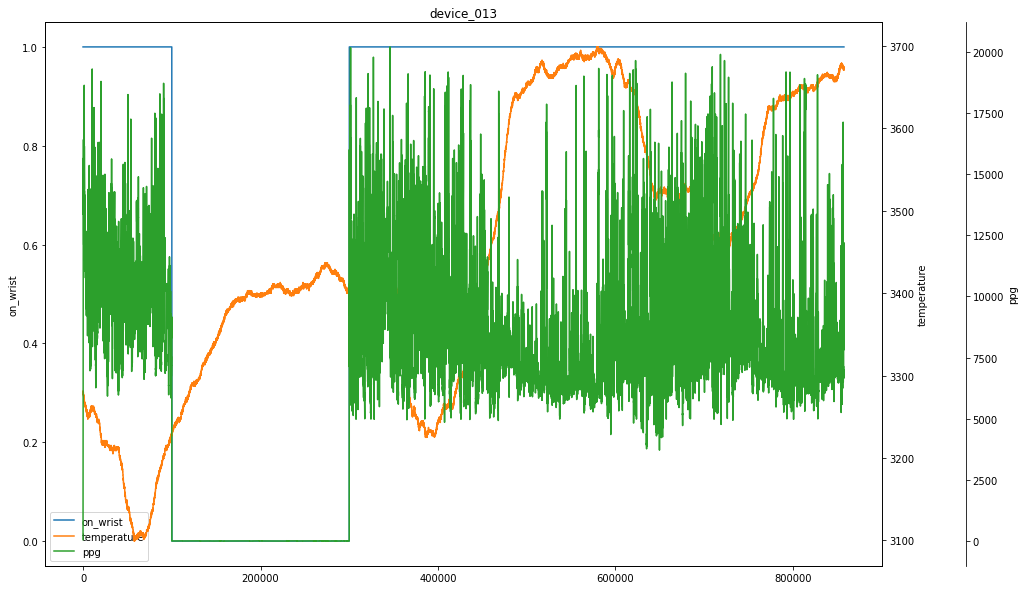

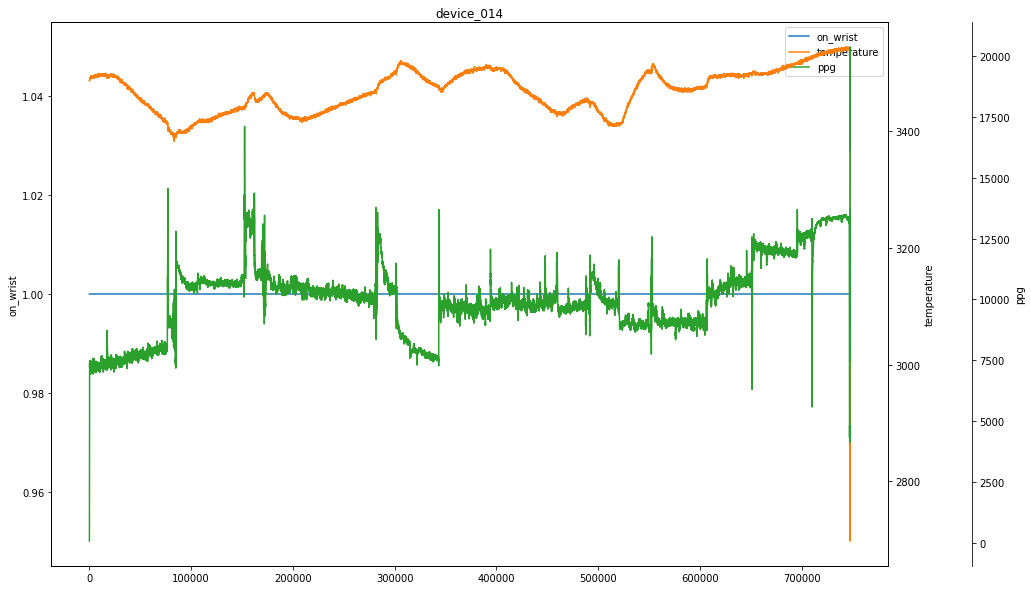

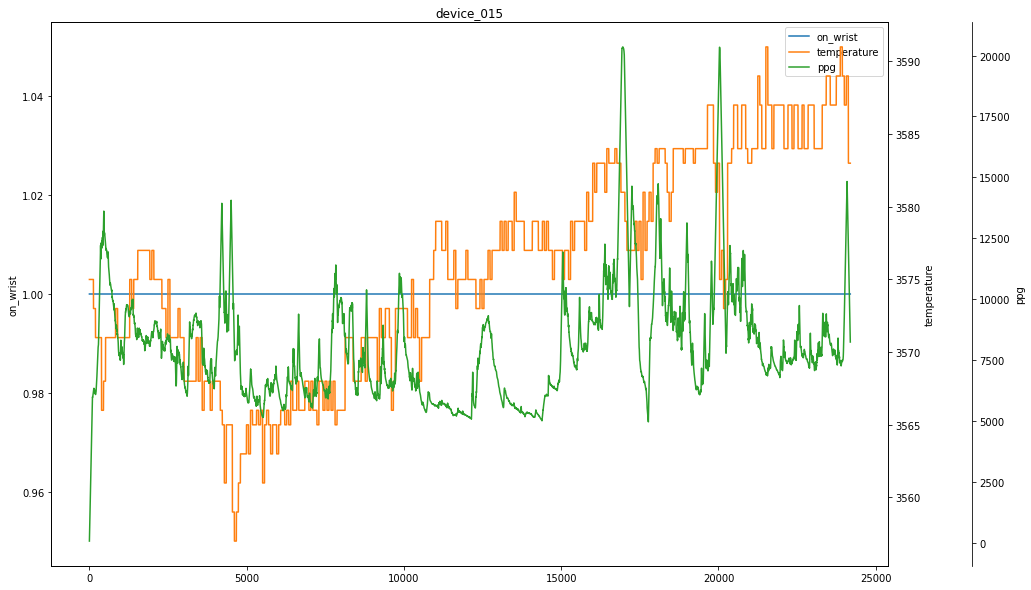

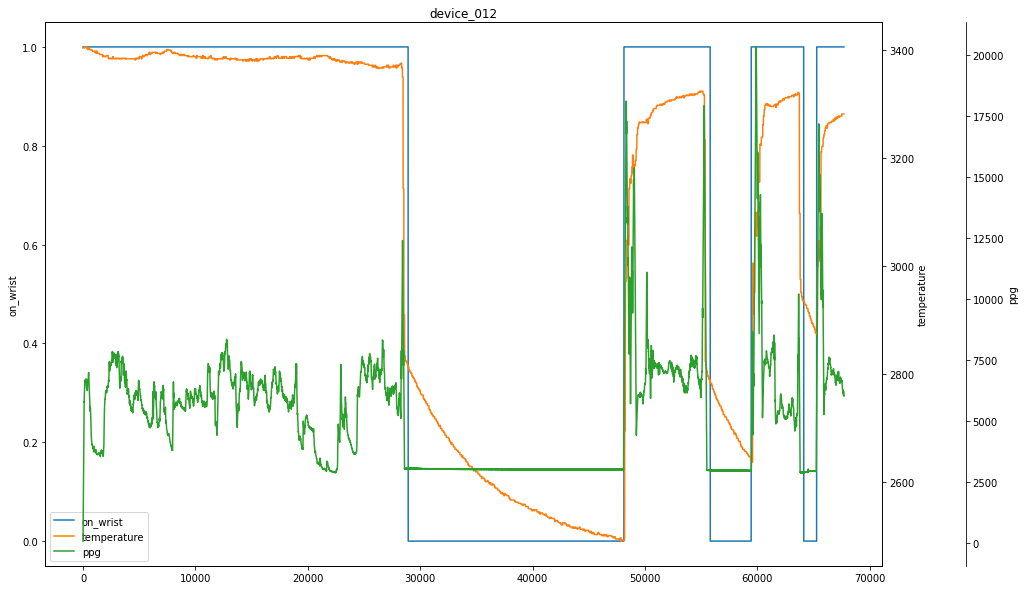

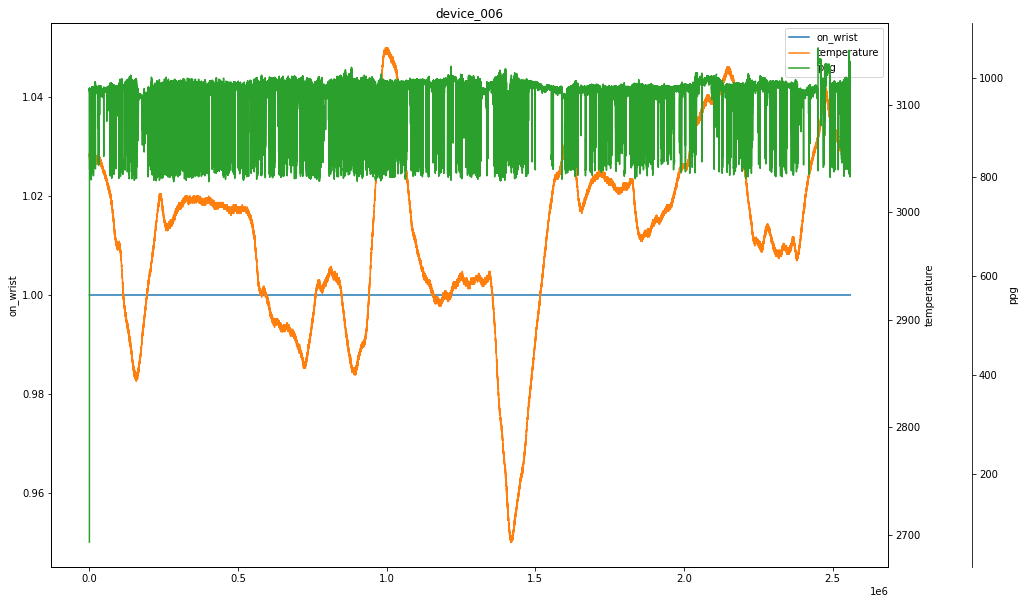

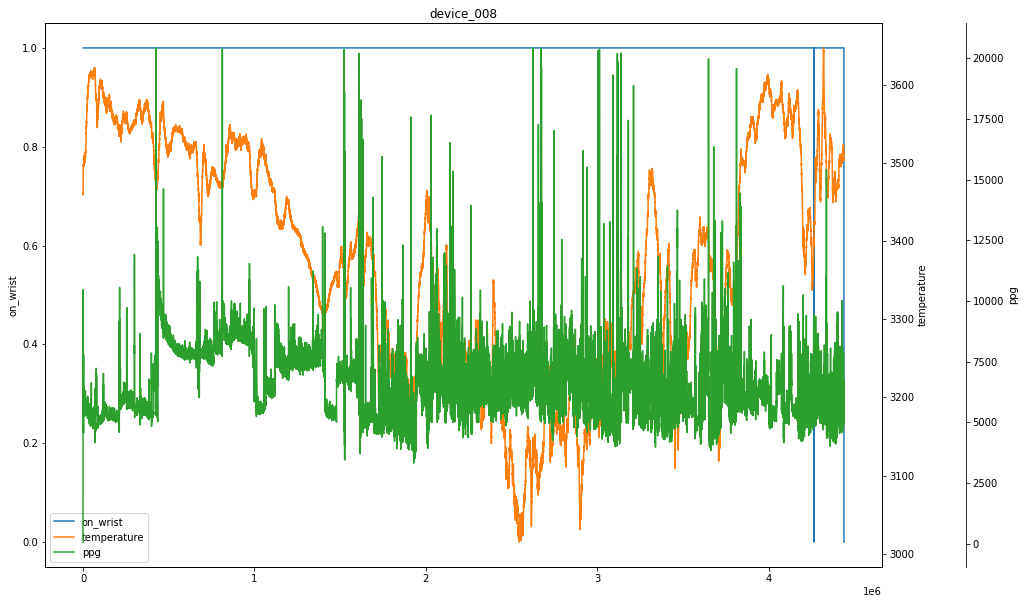

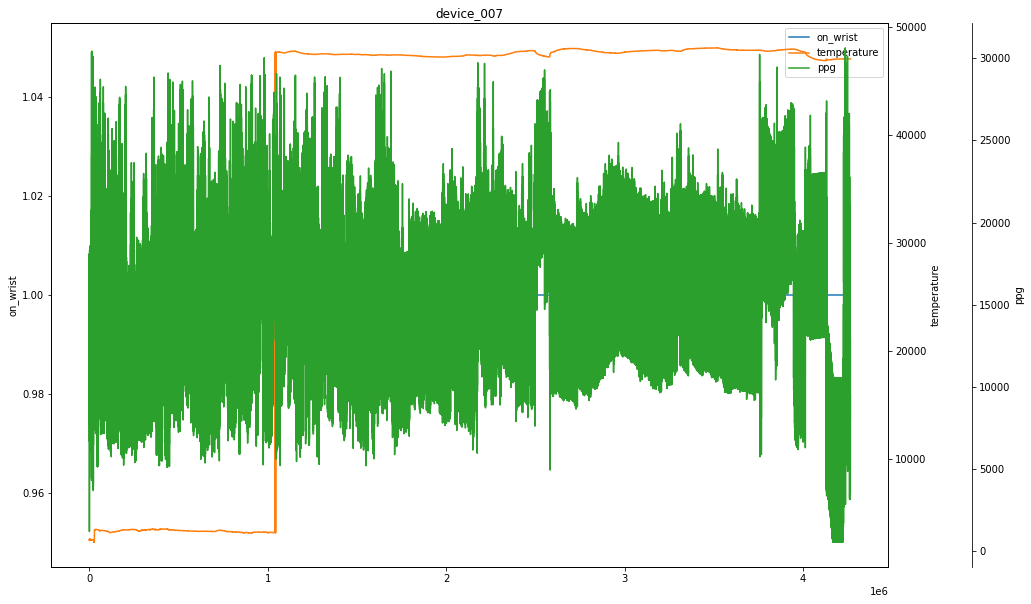

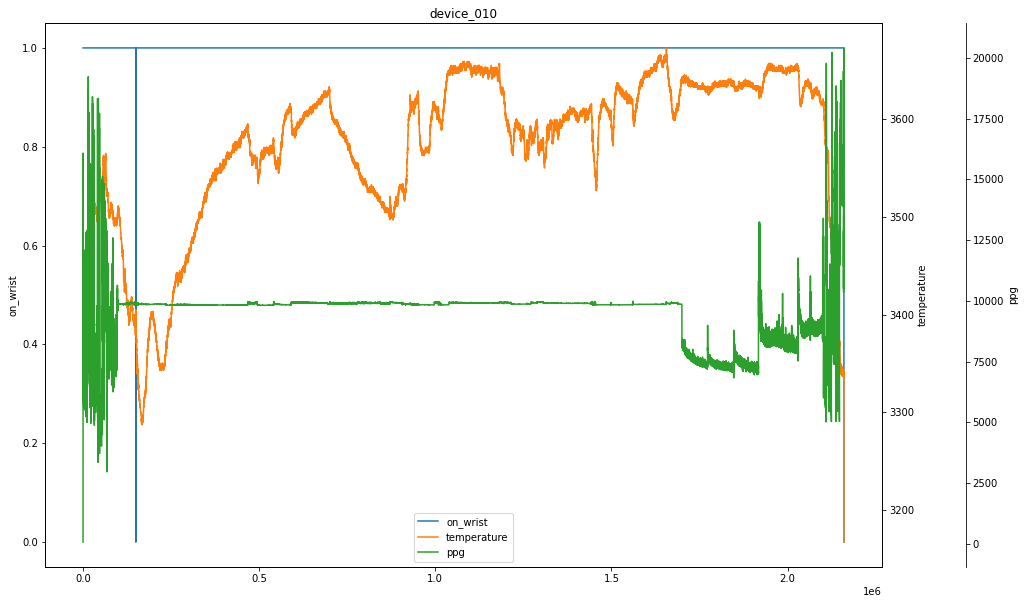

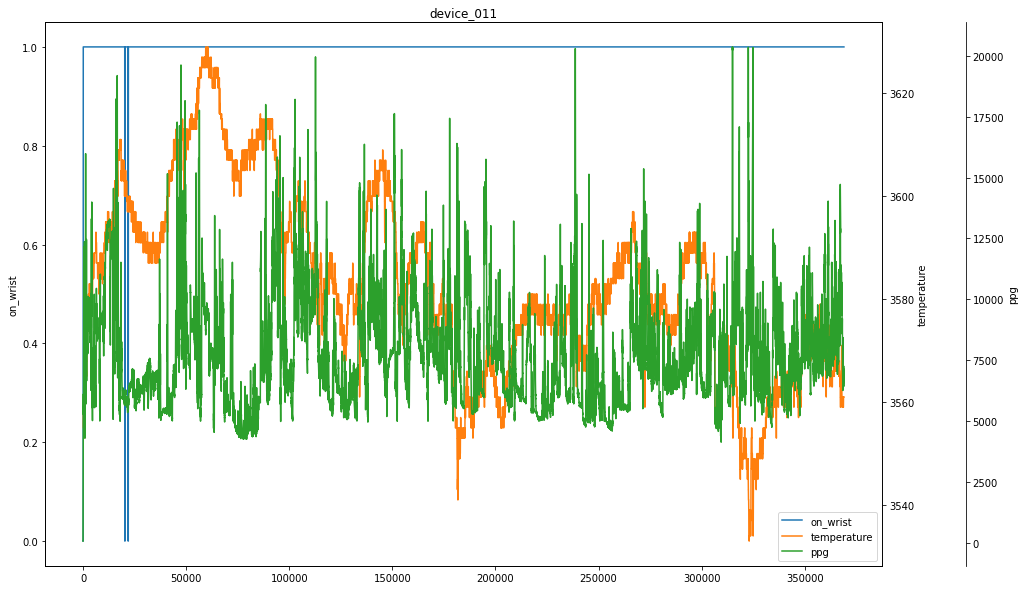

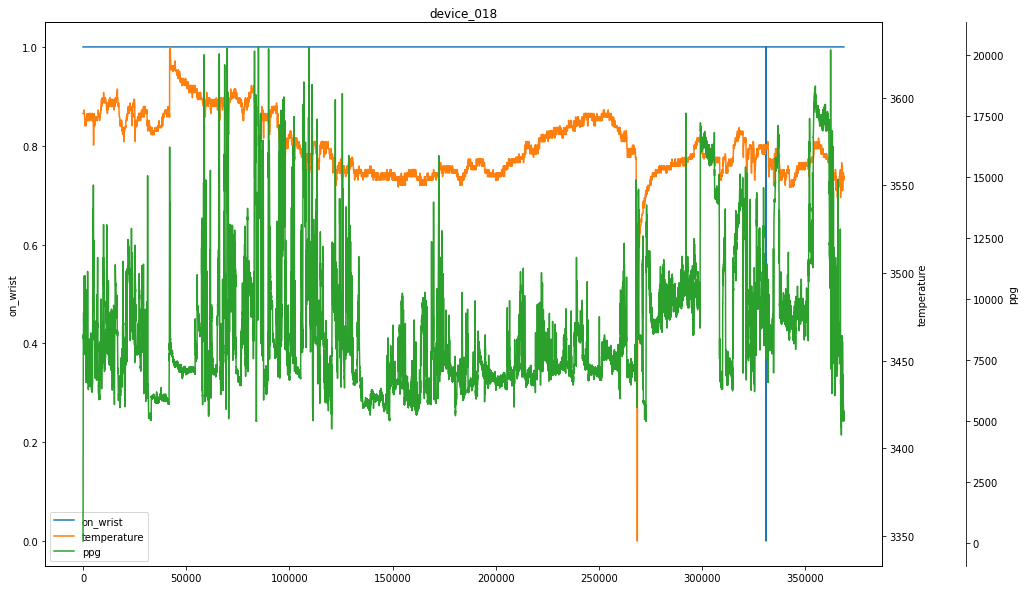

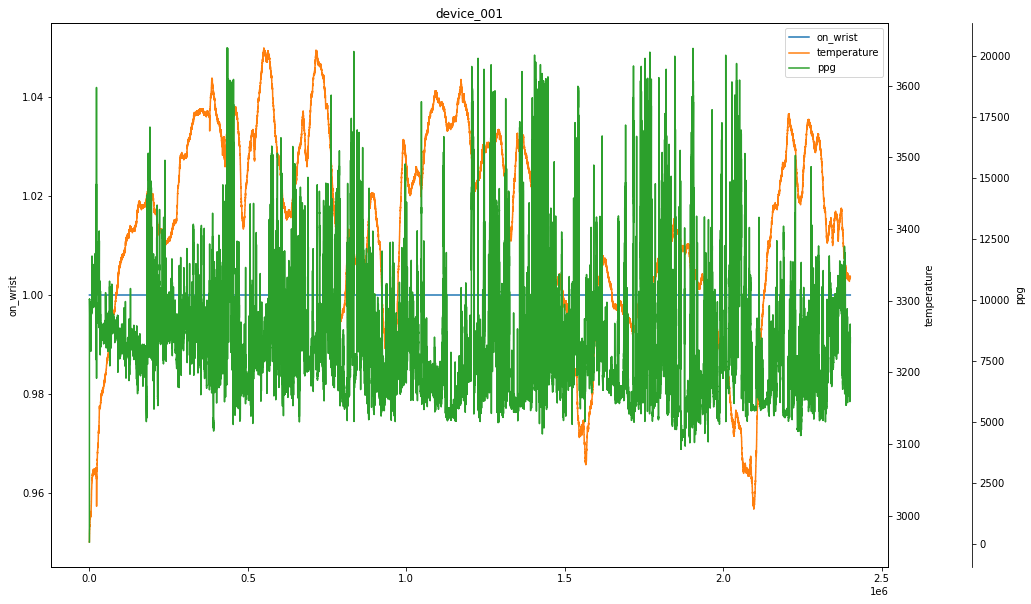

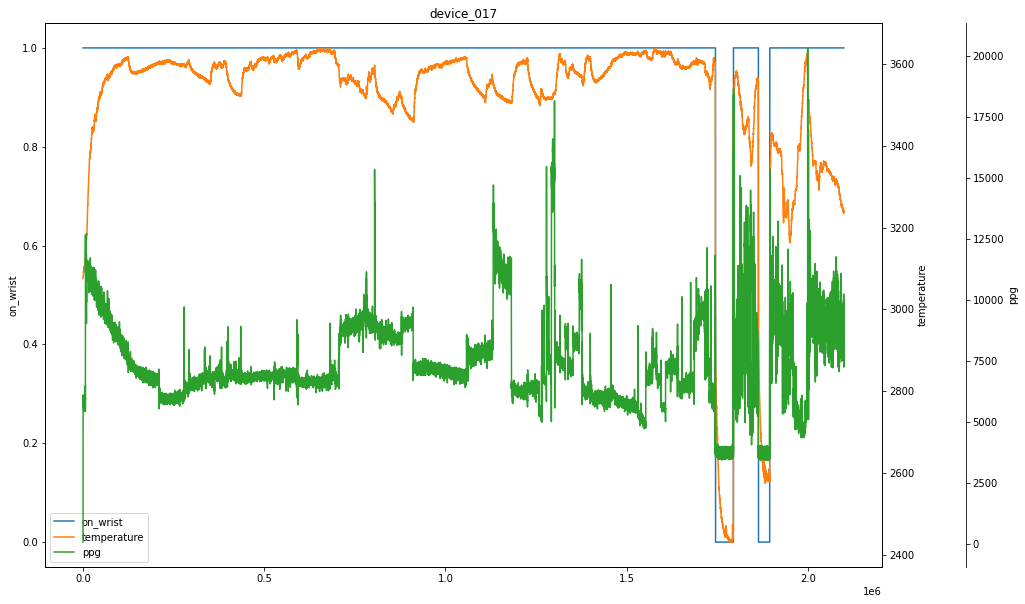

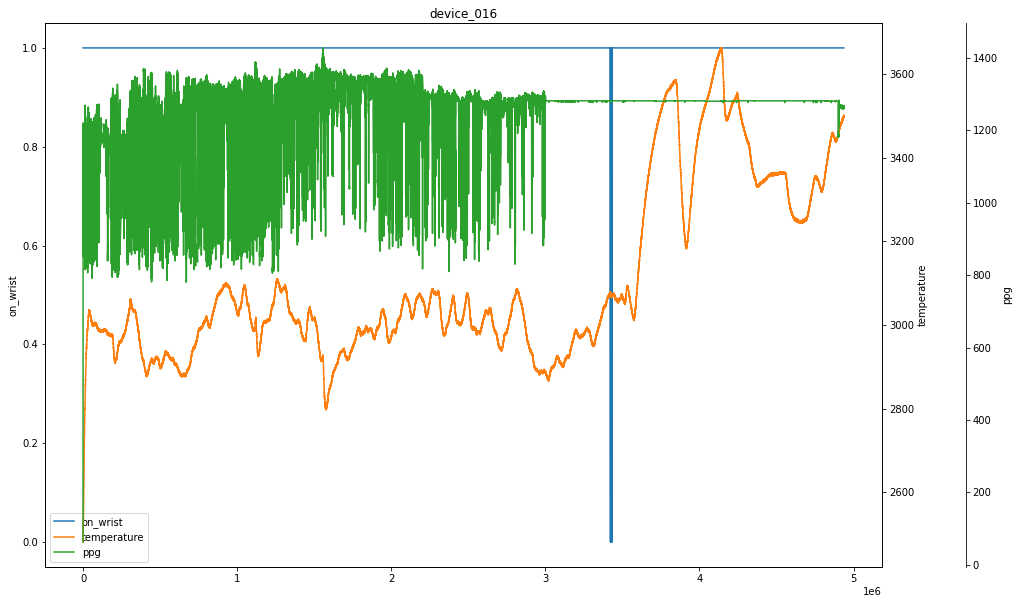

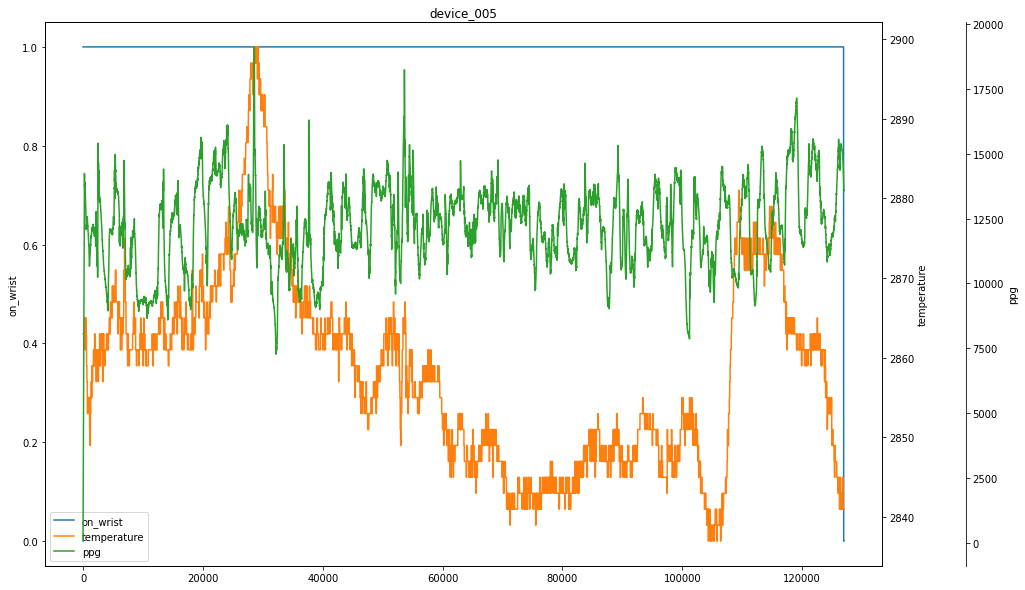

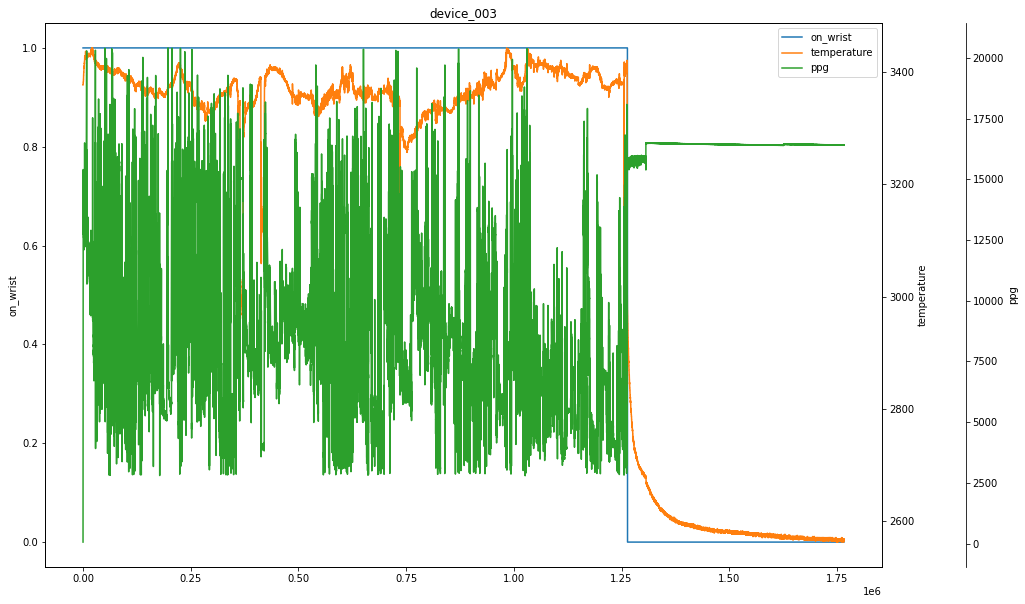

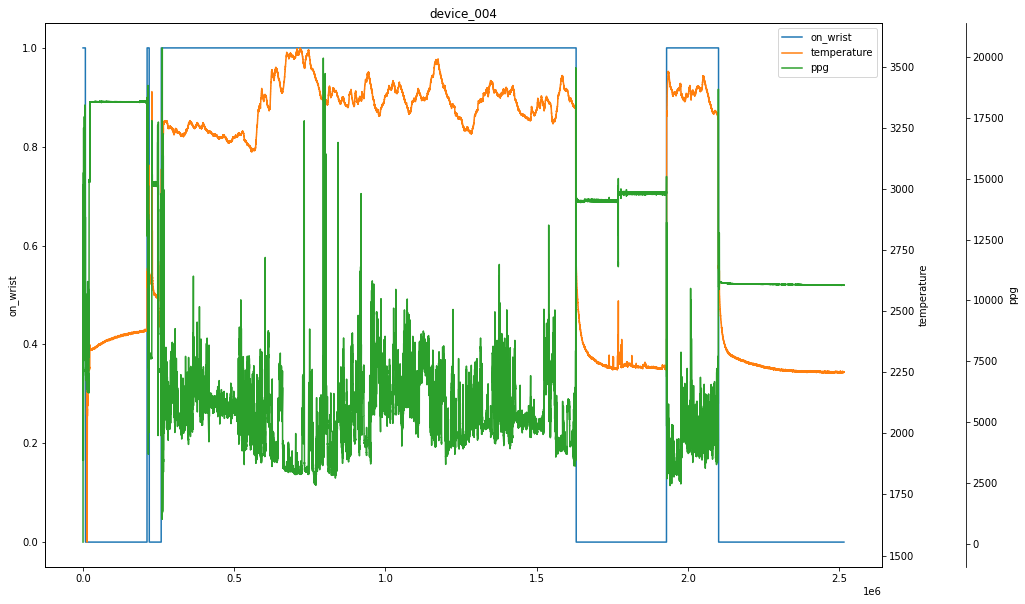

In [3]:
for root, d, files in os.walk('raw_bucket'):
    if files and re.match(r'raw_bucket/\d{4}/\d{2}/\d{2}/device_\d{3}', root):
        csvs = [os.path.join(root, file) for file in files if file.endswith('csv')]
        dfs = [pd.read_csv(path, header=None) for path in csvs]
        
        on_wrist = dfs[0].loc[dfs[0].index.repeat(64)].reset_index(drop=True)
        temperature = dfs[1].loc[dfs[1].index.repeat(16)].reset_index(drop=True)
        ppg = dfs[2]
            
        wrist_samples = len(on_wrist)
        temp_samples = len(temperature)
        ppg_samples = len(ppg)
            
        cut_off = min(wrist_samples, temp_samples, ppg_samples)
            
        complete = pd.DataFrame({
                'on_wrist': on_wrist[0][:cut_off],
                'temperature': temperature[0][:cut_off],
                'ppg': ppg[0][:cut_off]
                
        })
        device_name = root.split('/')[-1]
        plot_device_data(complete, device_name, figsize=(15, 10))

## 3. Simulation for 3 days

In [2]:
from datetime import date
from check_faulty_devices.check_devices import process_day

days = ['2021-02-02', '2021-02-03', '2021-02-04']

for day in days:
    process_day(date.fromisoformat(day))


Device device_003 is malfunctioning!
Explanation:
{
    "wrist_on": {
        "1": {
            "temperature_over_std_threshold": false,
            "ppg_over_std_threshold": false,
            "temperature_outside_range": false
        }
    },
    "wrist_off": {
        "1": {
            "ppg_over_threshold": false,
            "is_temperature_increasing": false,
            "is_ppg_increasing": true
        }
    }
}
-------------


Device device_017 is malfunctioning!
Explanation:
{
    "wrist_on": {
        "1": {
            "temperature_over_std_threshold": false,
            "ppg_over_std_threshold": false,
            "temperature_outside_range": false
        },
        "2": {
            "temperature_over_std_threshold": false,
            "ppg_over_std_threshold": false,
            "temperature_outside_range": true
        },
        "3": {
            "temperature_over_std_threshold": false,
            "ppg_over_std_threshold": false,
            "temperature_outside_


Device device_013 is malfunctioning!
Explanation:
{
    "wrist_on": {
        "1": {
            "temperature_over_std_threshold": false,
            "ppg_over_std_threshold": false,
            "temperature_outside_range": false
        },
        "2": {
            "temperature_over_std_threshold": false,
            "ppg_over_std_threshold": false,
            "temperature_outside_range": false
        }
    },
    "wrist_off": {
        "1": {
            "ppg_over_threshold": false,
            "is_temperature_increasing": true,
            "is_ppg_increasing": true
        }
    }
}
-------------


Device device_006 is malfunctioning!
Explanation:
{
    "wrist_on": {
        "1": {
            "temperature_over_std_threshold": false,
            "ppg_over_std_threshold": false,
            "temperature_outside_range": true
        }
    },
    "wrist_off": {}
}
-------------


Device device_007 is malfunctioning!
Explanation:
{
    "wrist_on": {
        "1": {
            "tempe